In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost

### Kaggle Model

In [472]:
train = pd.read_csv('./spaceship-titanic/CS559_S23_Competition_Data/train_.csv', index_col='Unnamed: 0')
test = pd.read_csv('./spaceship-titanic/CS559_S23_Competition_Data/test_.csv', index_col='Unnamed: 0')
validation = pd.read_csv('./spaceship-titanic/CS559_S23_Competition_Data/validation_.csv', index_col='Unnamed: 0')
train.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,3856_01,Earth,False,F/726/S,NaN,23.0,False,339.0,754.0,7.0,0.0,0.0,Ward Alvasquez,True
1,6110_01,Earth,False,E/389/P,55 Cancri e,57.0,False,0.0,0.0,0.0,0.0,642.0,Sus Warrishales,True
2,6908_01,Europa,False,C/254/S,TRAPPIST-1e,60.0,False,0.0,960.0,46.0,854.0,17074.0,Sheleon Swinvul,False
3,5628_01,Earth,True,G/900/P,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Ebonya Potthews,False
4,1193_02,Europa,True,B/50/S,55 Cancri e,25.0,False,0.0,0.0,0.0,0.0,0.0,Solam Presstic,True
5,3987_01,Earth,False,F/822/P,TRAPPIST-1e,17.0,False,103.0,2183.0,0.0,16.0,0.0,Irmark Briggston,True
6,5163_02,Earth,False,E/322/P,TRAPPIST-1e,40.0,False,151.0,0.0,713.0,0.0,0.0,Jillie Hewson,True
7,4840_01,NaN,True,F/915/S,TRAPPIST-1e,36.0,False,0.0,0.0,NaN,0.0,0.0,NaN,True
8,5934_01,Earth,False,G/962/P,TRAPPIST-1e,29.0,False,89.0,1725.0,NaN,0.0,3.0,Joanry Mcfaddenson,True
9,2090_01,Earth,False,F/413/P,TRAPPIST-1e,22.0,False,8.0,0.0,801.0,0.0,12.0,Dia Watkinsley,True


In [473]:
print(train.shape)
print(test.shape)
print(validation.shape)

(6258, 14)
(1739, 14)
(696, 14)


In [474]:
train.isna().sum()

PassengerId       0
HomePlanet      142
CryoSleep       156
Cabin           144
Destination     122
Age             130
VIP             152
RoomService     126
FoodCourt       126
ShoppingMall    151
Spa             118
VRDeck          129
Name            145
Transported       0
dtype: int64

In [475]:
train.nunique().sort_values()

CryoSleep          2
VIP                2
Transported        2
HomePlanet         3
Destination        3
Age               79
ShoppingMall     916
RoomService     1050
VRDeck          1052
Spa             1075
FoodCourt       1187
Cabin           4988
Name            6102
PassengerId     6258
dtype: int64

In [476]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

### EDA

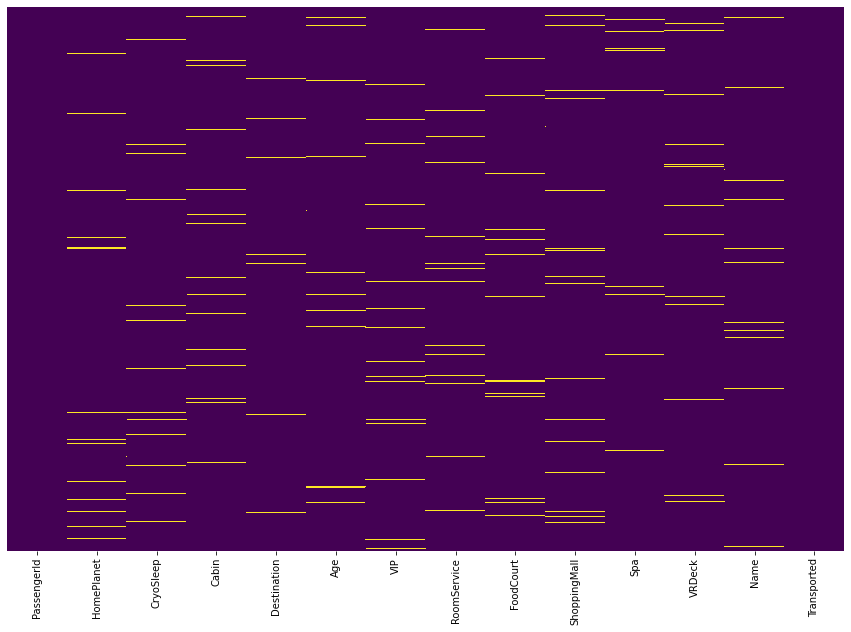

In [477]:
fig, axes = plt.subplots(figsize=(15,10))
sns.heatmap(train.isnull(), yticklabels=False, cbar = False, cmap = 'viridis', ax = axes)
plt.show()

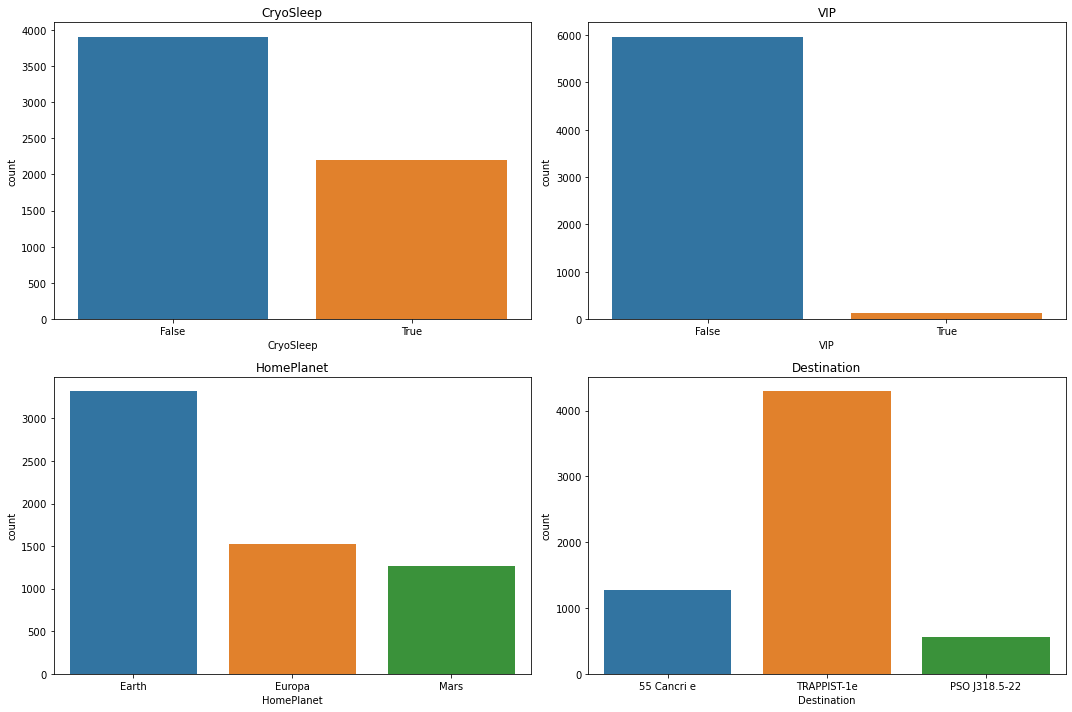

In [478]:
#View the distribution of the categorical variables
categorical_columns = ['CryoSleep', 'VIP', 'HomePlanet', 'Destination']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, column in enumerate(categorical_columns):
    sns.countplot(data=train, x=column, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

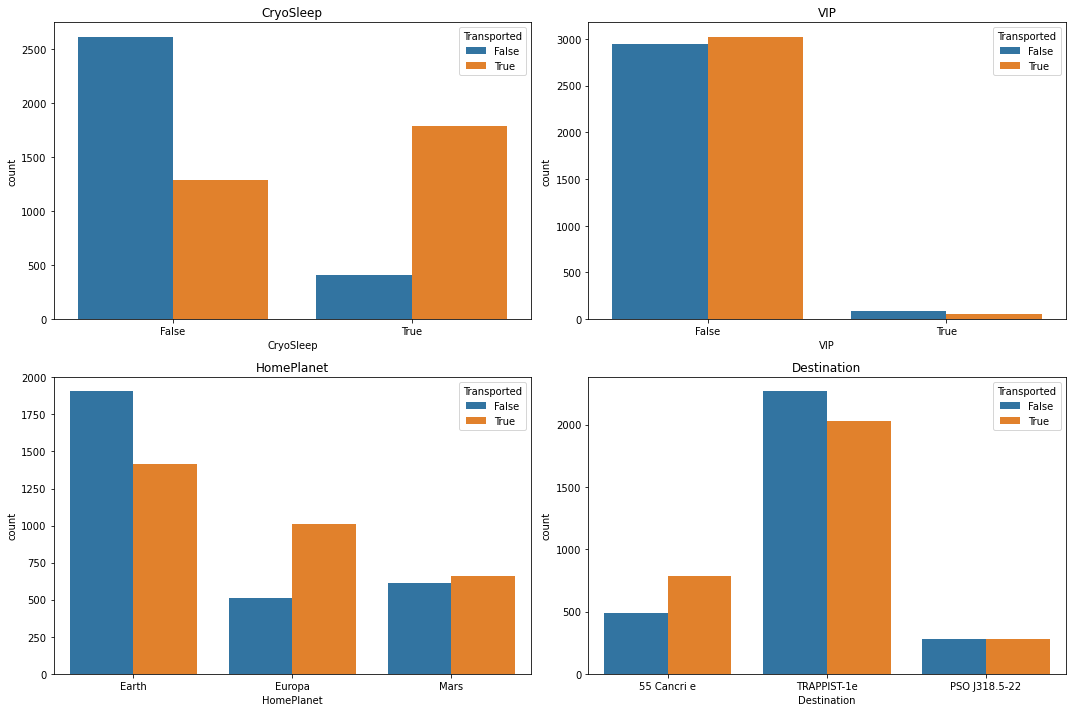

In [479]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, column in enumerate(categorical_columns):
    sns.countplot(data=train, x=column, ax=axes[i], hue='Transported')
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

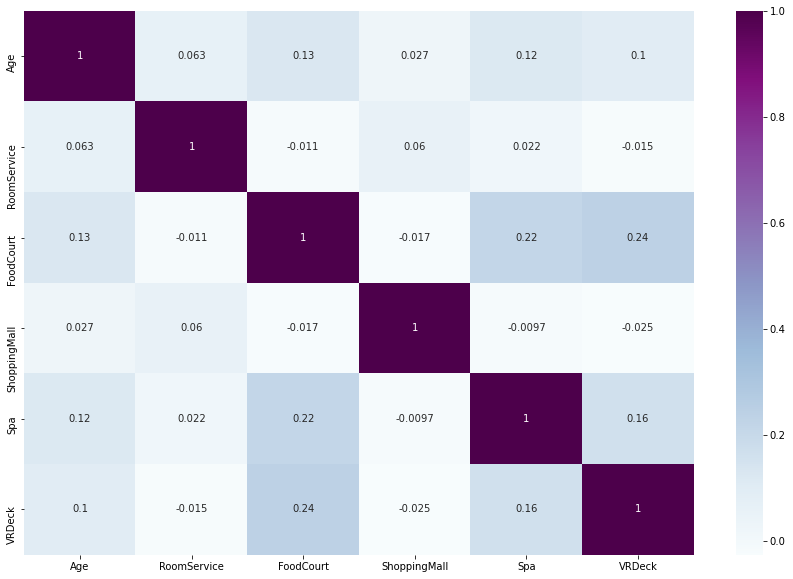

In [480]:
#View the correlation between numerical features. As we can see, SibSp and Parch have a relatively high correlation
numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig, axes = plt.subplots(figsize=(15,10))
sns.heatmap(train[numerical_columns].corr(), annot=True, cmap='BuPu', ax=axes)
plt.show()

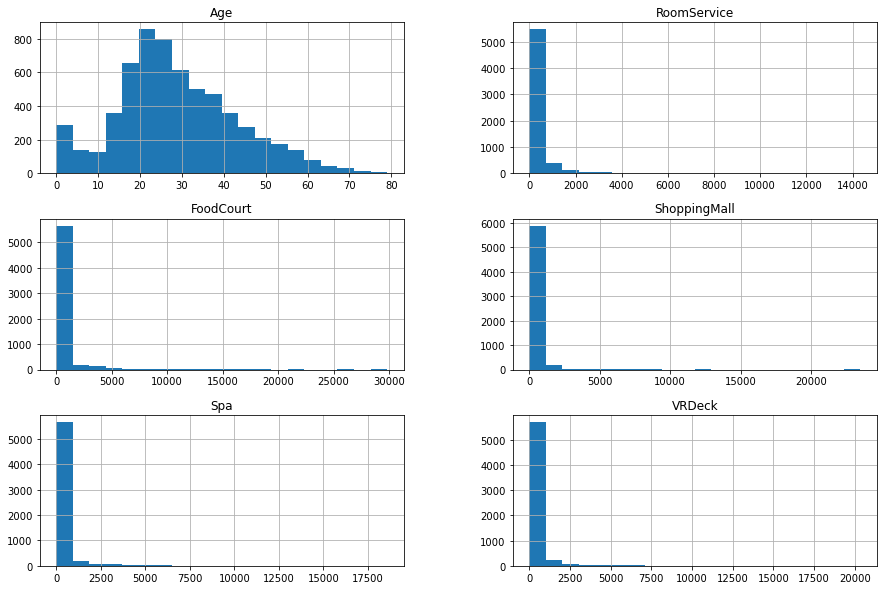

In [481]:
train[numerical_columns].hist(bins=20, figsize=(15,10))
plt.show()

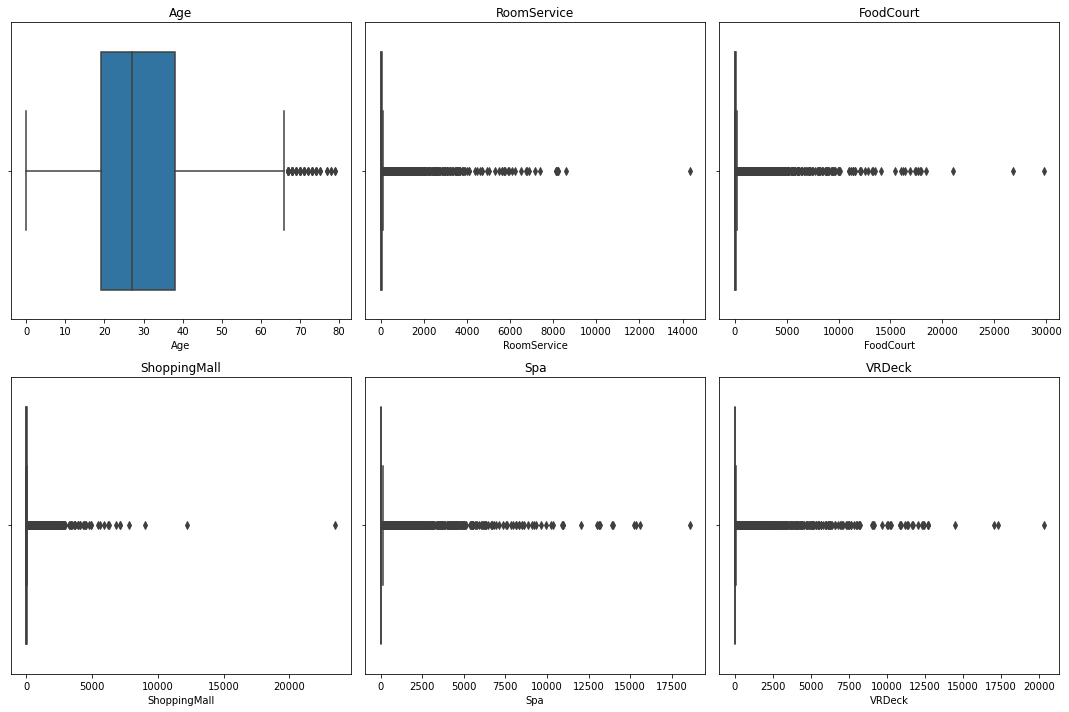

In [482]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
for i, column in enumerate(numerical_columns):
    sns.boxplot(x=column, data=train, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

### Pre-processing

In [483]:
train = train.drop('Name', axis = 1)
test = test.drop('Name', axis = 1)
validation = validation.drop('Name', axis = 1)

In [484]:
#extracting group info from passengerID
train['Group'] = train['PassengerId'].str.split('_').str[0]
test['Group'] = test['PassengerId'].str.split('_').str[0]
validation['Group'] = validation['PassengerId'].str.split('_').str[0]
#getting the group size from group
group_size_train = train['Group'].value_counts().to_dict()
group_size_test = test['Group'].value_counts().to_dict()
group_size_validation = validation['Group'].value_counts().to_dict()

train['GroupSize'] = train['Group'].map(group_size_train)
test['GroupSize'] = test['Group'].map(group_size_test)
validation['GroupSize'] = validation['Group'].map(group_size_validation)

train.drop('Group', axis=1, inplace=True)
test.drop('Group', axis=1, inplace=True)
validation.drop('Group', axis=1, inplace=True)

In [485]:
train[['Deck','Num', 'Side']] = train['Cabin'].str.split('/', expand=True)
test[['Deck','Num', 'Side']] = test['Cabin'].str.split('/', expand=True)
validation[['Deck','Num', 'Side']] = validation['Cabin'].str.split('/', expand=True)

train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)
validation.drop('Cabin', axis=1, inplace=True)

In [486]:
train['Num'] = pd.to_numeric(train['Num'])
test['Num'] = pd.to_numeric(test['Num'])
validation['Num'] = pd.to_numeric(validation['Num'])

In [487]:
billed = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train['TotalSpent'] = train[billed].sum(axis=1)
test['TotalSpent'] = test[billed].sum(axis=1)
validation['TotalSpent'] = validation[billed].sum(axis=1)

In [488]:
numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Num', 'TotalSpent', 'GroupSize']
categorical_columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']

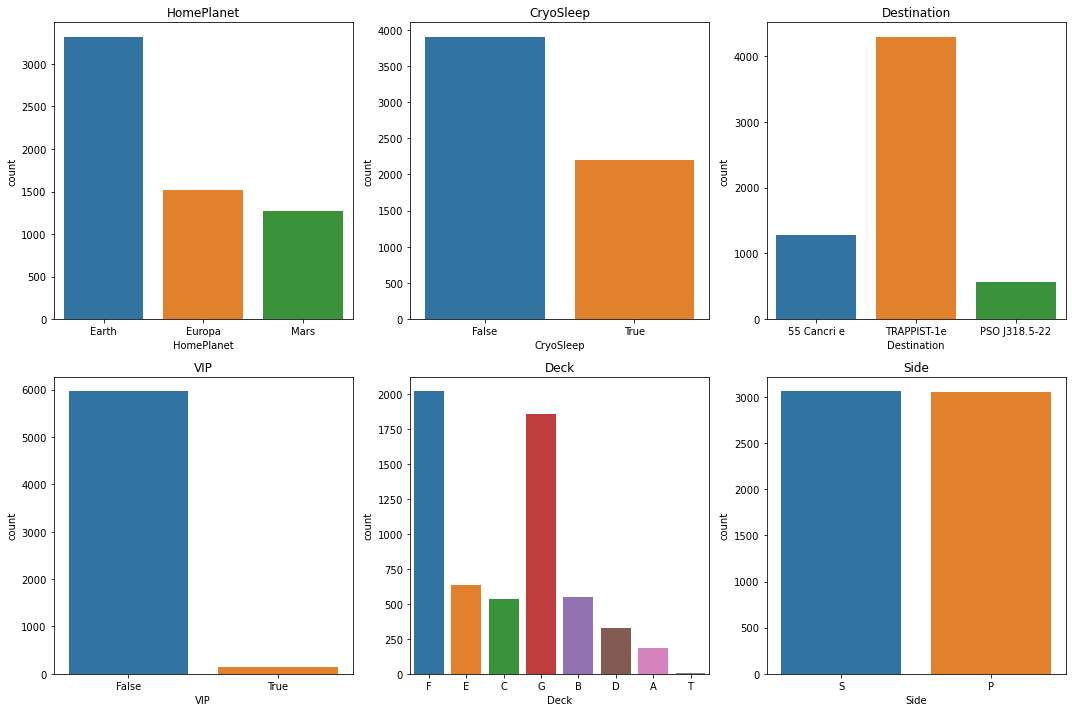

In [489]:
#View the distribution of the categorical variables
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, column in enumerate(categorical_columns):
    sns.countplot(data=train, x=column, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

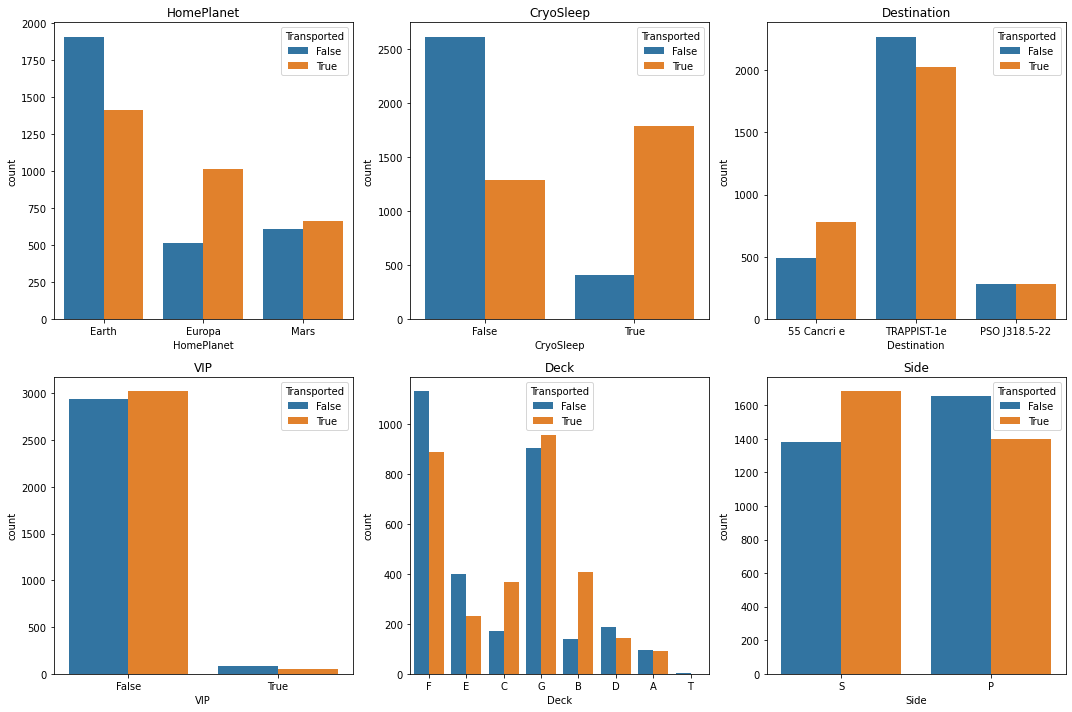

In [490]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, column in enumerate(categorical_columns):
    sns.countplot(data=train, x=column, ax=axes[i], hue='Transported')
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

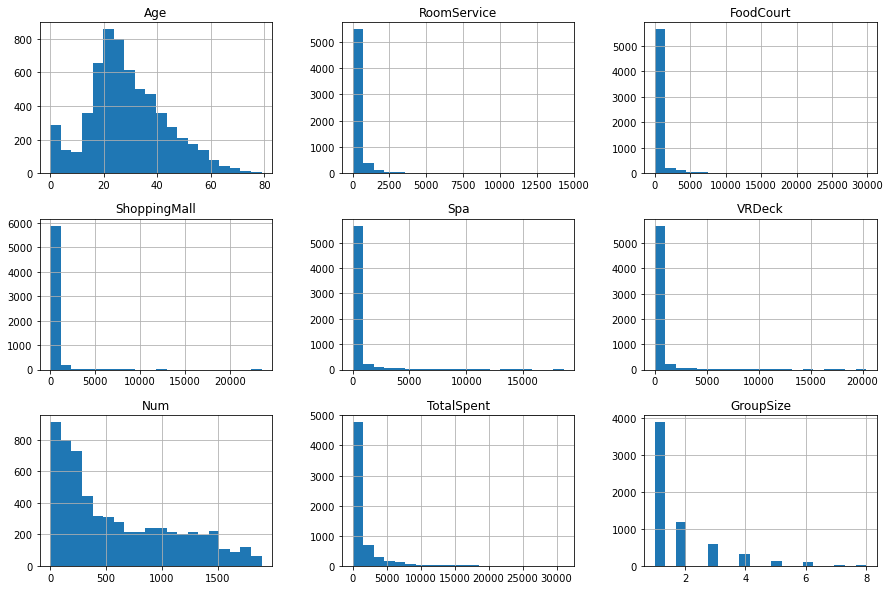

In [491]:
train[numerical_columns].hist(bins=20, figsize=(15,10))
plt.show()

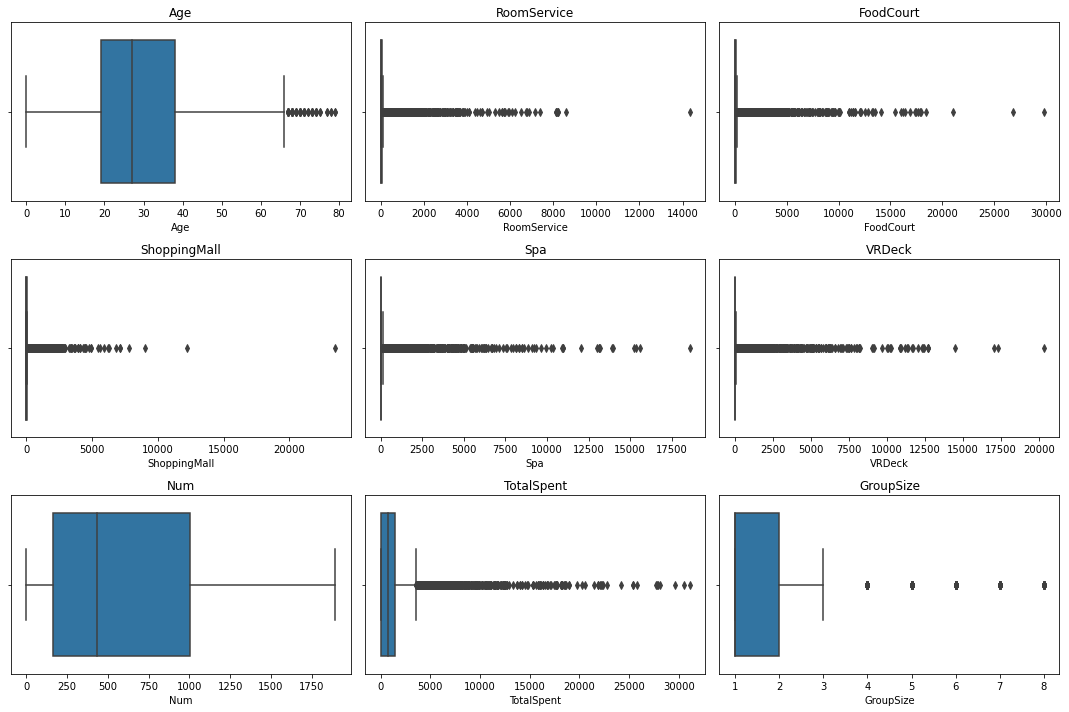

In [492]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.ravel()
for i, column in enumerate(numerical_columns):
    sns.boxplot(x=column, data=train, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

In [493]:
#impute numerical columns with median
for col in numerical_columns:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(test[col].median(), inplace=True)
    validation[col].fillna(validation[col].median(), inplace=True)

#impute categorical columns with mode
for col in categorical_columns:
    train[col].fillna(train[col].mode()[0], inplace=True)
    test[col].fillna(test[col].mode()[0], inplace=True)
    validation[col].fillna(validation[col].mode()[0], inplace=True)

In [494]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupSize,Deck,Num,Side,TotalSpent
0,3856_01,Earth,False,TRAPPIST-1e,23.0,False,339.0,754.0,7.0,0.0,0.0,True,1,F,726.0,S,1100.0
1,6110_01,Earth,False,55 Cancri e,57.0,False,0.0,0.0,0.0,0.0,642.0,True,1,E,389.0,P,642.0
2,6908_01,Europa,False,TRAPPIST-1e,60.0,False,0.0,960.0,46.0,854.0,17074.0,False,1,C,254.0,S,18934.0
3,5628_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,False,1,G,900.0,P,0.0
4,1193_02,Europa,True,55 Cancri e,25.0,False,0.0,0.0,0.0,0.0,0.0,True,1,B,50.0,S,0.0


In [495]:
train.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
GroupSize       0
Deck            0
Num             0
Side            0
TotalSpent      0
dtype: int64

In [496]:
train.nunique().sort_values()

CryoSleep          2
VIP                2
Side               2
Transported        2
HomePlanet         3
Destination        3
GroupSize          8
Deck               8
Age               79
ShoppingMall     916
RoomService     1050
VRDeck          1052
Spa             1075
FoodCourt       1187
Num             1724
TotalSpent      1847
PassengerId     6258
dtype: int64

In [497]:
train['Transported'] = train['Transported'].astype(int)
test['Transported'] = test['Transported'].astype(int)
validation['Transported'] = validation['Transported'].astype(int)

train['CryoSleep'] = train['CryoSleep'].astype(int)
test['CryoSleep'] = test['CryoSleep'].astype(int)
validation['CryoSleep'] = validation['CryoSleep'].astype(int)

train['VIP'] = train['VIP'].astype(int)
test['VIP'] = test['VIP'].astype(int)
validation['VIP'] = validation['VIP'].astype(int)

In [498]:
categorical_columns_to_onehot = ['HomePlanet', 'Destination', 'Side', 'Deck']

train = pd.get_dummies(train, columns=categorical_columns_to_onehot)
test = pd.get_dummies(test, columns=categorical_columns_to_onehot)
validation = pd.get_dummies(validation, columns=categorical_columns_to_onehot)

In [499]:
train.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,...,Side_P,Side_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,3856_01,0,23.0,0,339.0,754.0,7.0,0.0,0.0,1,...,0,1,0,0,0,0,0,1,0,0
1,6110_01,0,57.0,0,0.0,0.0,0.0,0.0,642.0,1,...,1,0,0,0,0,0,1,0,0,0
2,6908_01,0,60.0,0,0.0,960.0,46.0,854.0,17074.0,0,...,0,1,0,0,1,0,0,0,0,0
3,5628_01,1,27.0,0,0.0,0.0,0.0,0.0,0.0,0,...,1,0,0,0,0,0,0,0,1,0
4,1193_02,1,25.0,0,0.0,0.0,0.0,0.0,0.0,1,...,0,1,0,1,0,0,0,0,0,0


In [500]:
train.isna().sum()

PassengerId                  0
CryoSleep                    0
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Transported                  0
GroupSize                    0
Num                          0
TotalSpent                   0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
Side_P                       0
Side_S                       0
Deck_A                       0
Deck_B                       0
Deck_C                       0
Deck_D                       0
Deck_E                       0
Deck_F                       0
Deck_G                       0
Deck_T                       0
dtype: int64

In [501]:
train.shape

(6258, 29)

In [502]:
numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize', 'Num', 'TotalSpent']
scale = StandardScaler()
scale.fit(train[numerical_columns])
train[numerical_columns] = scale.transform(train[numerical_columns])
test[numerical_columns] = scale.transform(test[numerical_columns])
validation[numerical_columns] = scale.transform(validation[numerical_columns])


### Data Split

In [176]:
train_X = train.drop(['Transported', 'PassengerId'], axis = 1)
train_y = train['Transported']

test_X = test.drop(['Transported', 'PassengerId'], axis = 1)
test_y = test['Transported']

valid_X = validation.drop(['Transported', 'PassengerId'], axis = 1)
valid_y = validation['Transported']

### Random Forest

In [177]:
rf_param_grid = {
    'max_depth': [10],
    'min_samples_split':[10, 20],
    'min_samples_leaf':[5, 10],
    'max_features':[3, 4, 5]
}

In [178]:
rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, rf_param_grid, scoring='accuracy', cv = 5, n_jobs=-1)
rf_grid.fit(valid_X, valid_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10], 'max_features': [3, 4, 5],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [10, 20]},
             scoring='accuracy')

In [179]:
print(rf_grid.best_params_)
print(rf_grid.best_score_)

{'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 20}
0.795960945529291


In [180]:
rf_tuned = RandomForestClassifier(**rf_grid.best_params_)
rf_tuned.fit(train_X, train_y)

RandomForestClassifier(max_depth=10, max_features=5, min_samples_leaf=5,
                       min_samples_split=20)

In [181]:
train_pred = rf_tuned.predict(train_X)
test_pred = rf_tuned.predict(test_X)
print(f'Train Accuracy: {accuracy_score(train_y, train_pred)}')
print(f'Test Accuracy: {accuracy_score(test_y, test_pred)}')

Train Accuracy: 0.8387663790348354
Test Accuracy: 0.8085106382978723


### Logistic Regression

In [182]:
lr_param_grid = {
    'solver':['liblinear'],
    'penalty':['l1', 'l2'],
    'C':[5, 10],
    'max_iter':[500]
}

In [183]:
lr = LogisticRegression()
lr_grid = GridSearchCV(lr, lr_param_grid, scoring='accuracy', cv = 5, n_jobs=-1)
lr_grid.fit(valid_X, valid_y)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [5, 10], 'max_iter': [500],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy')

In [184]:
print(lr_grid.best_params_)
print(lr_grid.best_score_)

{'C': 5, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
0.7988386433710175


In [185]:
lr_tuned = LogisticRegression(**lr_grid.best_params_)
lr_tuned.fit(train_X, train_y)

LogisticRegression(C=5, max_iter=500, penalty='l1', solver='liblinear')

In [186]:
train_pred = lr_tuned.predict(train_X)
test_pred = lr_tuned.predict(test_X)
print(f'Train Accuracy: {accuracy_score(train_y, train_pred)}')
print(f'Test Accuracy: {accuracy_score(test_y, test_pred)}')

Train Accuracy: 0.7893895813358901
Test Accuracy: 0.8016101207590569


### Gradient Boosted

In [192]:
gbc_param_grid = {
    'max_depth': [5],
    'min_samples_split':[10, 20],
    'min_samples_leaf':[5, 10],
    'max_features':[3, 4, 5],
    'learning_rate': [.1]
}

In [193]:
gbc = GradientBoostingClassifier()
gbc_grid = GridSearchCV(gbc, gbc_param_grid, scoring='accuracy', cv = 5, n_jobs=-1)
gbc_grid.fit(valid_X, valid_y)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [5],
                         'max_features': [3, 4, 5], 'min_samples_leaf': [5, 10],
                         'min_samples_split': [10, 20]},
             scoring='accuracy')

In [194]:
print(gbc_grid.best_params_)
print(gbc_grid.best_score_)

{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 5, 'min_samples_split': 10}
0.8146968139773895


In [195]:
gbc_tuned = GradientBoostingClassifier(**gbc_grid.best_params_)
gbc_tuned.fit(train_X, train_y)

GradientBoostingClassifier(max_depth=5, max_features=4, min_samples_leaf=5,
                           min_samples_split=10)

In [196]:
train_pred = gbc_tuned.predict(train_X)
test_pred = gbc_tuned.predict(test_X)
print(f'Train Accuracy: {accuracy_score(train_y, train_pred)}')
print(f'Test Accuracy: {accuracy_score(test_y, test_pred)}')

Train Accuracy: 0.8505912432086928
Test Accuracy: 0.8148361127084531


### XGBoost

In [197]:
xgb_param_grid = {'eta':[.04, .05, .06],
                  'max_depth':[5],
                  'gamma':[.03, .035, .04],
                  'subsample':[.35, .4, .45]}

In [198]:
xgb = xgboost.XGBClassifier()
xgb_grid = GridSearchCV(xgb, xgb_param_grid, scoring='accuracy', cv = 5, n_jobs=-1)
xgb_grid.fit(valid_X, valid_y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                   

In [199]:
print(xgb_grid.best_params_)
print(xgb_grid.best_score_)

{'eta': 0.05, 'gamma': 0.035, 'max_depth': 5, 'subsample': 0.4}
0.8247173689619732


In [200]:
xgb_tuned = xgboost.XGBClassifier(**xgb_grid.best_params_)
xgb_tuned.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric=None,
              feature_types=None, gamma=0.035, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [201]:
train_pred = xgb_tuned.predict(train_X)
test_pred = xgb_tuned.predict(test_X)
print(f'Train Accuracy: {accuracy_score(train_y, train_pred)}')
print(f'Test Accuracy: {accuracy_score(test_y, test_pred)}')

Train Accuracy: 0.8410035155001598
Test Accuracy: 0.8154111558366878


### Simple NN

In [379]:
mlp_param_grid = {
    'hidden_layer_sizes':[[100], [250], [500]],
    #'solver':['lbfgs', 'sgd', 'adam'],
    #'activation':['logistic', 'tanh', 'relu'],
    'batch_size':[100],
    'max_iter':[100]
}

In [380]:
mlp = MLPClassifier()
mlp_grid = GridSearchCV(mlp, mlp_param_grid, scoring='accuracy', cv = 5, n_jobs=-1)
mlp_grid.fit(valid_X, valid_y)

c:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'batch_size': [100],
                         'hidden_layer_sizes': [[100], [250], [500]],
                         'max_iter': [100]},
             scoring='accuracy')

In [381]:
print(mlp_grid.best_params_)
print(mlp_grid.best_score_)

{'batch_size': 100, 'hidden_layer_sizes': [100], 'max_iter': 100}
0.8075231243576567


In [382]:
mlp_tuned = MLPClassifier(**mlp_grid.best_params_)
mlp_tuned.fit(train_X, train_y)

c:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(batch_size=100, hidden_layer_sizes=[100], max_iter=100)

In [383]:
train_pred = mlp_tuned.predict(train_X)
test_pred = mlp_tuned.predict(test_X)
print(f'Train Accuracy: {accuracy_score(train_y, train_pred)}')
print(f'Test Accuracy: {accuracy_score(test_y, test_pred)}')

Train Accuracy: 0.8405241291147332
Test Accuracy: 0.8182863714778609


### Linear SVM

In [367]:
svc_param_grid = {
    'kernel':['linear'],
    'C':[4, 5, 6]
}

In [368]:
svc = SVC()
svc_grid = GridSearchCV(svc, svc_param_grid, scoring='accuracy', cv = 5, n_jobs=-1)
svc_grid.fit(valid_X, valid_y)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [4, 5, 6], 'kernel': ['linear']},
             scoring='accuracy')

In [369]:
print(svc_grid.best_params_)
print(svc_grid.best_score_)

{'C': 5, 'kernel': 'linear'}
0.7988591983556013


In [370]:
svc_tuned = SVC(**svc_grid.best_params_)
svc_tuned.fit(train_X, train_y)

SVC(C=5, kernel='linear')

In [371]:
train_pred = svc_tuned.predict(train_X)
test_pred = svc_tuned.predict(test_X)
print(f'Train Accuracy: {accuracy_score(train_y, train_pred)}')
print(f'Test Accuracy: {accuracy_score(test_y, test_pred)}')

Train Accuracy: 0.7916267178012144
Test Accuracy: 0.8096607245543416


### Stacked

In [384]:
estimators = [('svc', svc_tuned), ('lr', lr_tuned), ('mlp', mlp_tuned), ('rf', rf_tuned), ('gbc', gbc_tuned), ('xgb', xgb_tuned)]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
stack.fit(train_X, train_y)

c:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\StevensUser\anaconda3\lib\site-packages

StackingClassifier(cv=5,
                   estimators=[('svc', SVC(C=5, kernel='linear')),
                               ('lr',
                                LogisticRegression(C=5, max_iter=500,
                                                   penalty='l1',
                                                   solver='liblinear')),
                               ('mlp',
                                MLPClassifier(batch_size=100,
                                              hidden_layer_sizes=[100],
                                              max_iter=100)),
                               ('rf',
                                RandomForestClassifier(max_depth=10,
                                                       max_features=5,
                                                       min_samples_leaf=5,
                                                       min_samples_split=20)),
                               ('gbc',
                                GradientBoostingClassif.

In [385]:
train_pred = stack.predict(train_X)
test_pred = stack.predict(test_X)
print(f'Train Accuracy: {accuracy_score(train_y, train_pred)}')
print(f'Test Accuracy: {accuracy_score(test_y, test_pred)}')

Train Accuracy: 0.847714924896133
Test Accuracy: 0.8171362852213916
